In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import numpy as np

# Read the data
df1 = pd.read_csv("./data/cardio_set1.csv", index_col=0)
df2 = pd.read_csv("./data/cardio_set2.csv", index_col=0)

In [11]:
# randomforest
# logistic regression
# svm - långsam
# knn
df2.info

<bound method DataFrame.info of          age  ap_hi  ap_lo  cholesterol  gluc  smoke  alco  active  cardio  \
id                                                                           
0      18393    110     80            1     1      0     0       1       0   
1      20228    140     90            3     1      0     0       1       1   
2      18857    130     70            3     1      0     0       0       1   
3      17623    150    100            1     1      0     0       1       1   
4      17474    100     60            1     1      0     0       0       0   
...      ...    ...    ...          ...   ...    ...   ...     ...     ...   
99993  19240    120     80            1     1      1     0       1       0   
99995  22601    140     90            2     2      0     0       1       1   
99996  19066    180     90            3     1      0     1       0       1   
99998  22431    135     80            1     2      0     0       0       1   
99999  20540    120     80      

In [12]:
X1, y1 = df1.drop(columns=["cardio"]), df1["cardio"]
X2, y2 = df2.drop(columns=["cardio"]), df2["cardio"]

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.29)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.29)

X1_test, X1_val, y1_test, y1_val = train_test_split(X1_test, y1_test, test_size=0.5)
X2_test, X2_val, y2_test, y2_val = train_test_split(X2_test, y2_test, test_size=0.5)

X1_test.shape, X1_val.shape, X1_train.shape

((9953, 18), (9954, 18), (48735, 18))

In [13]:
scaler_set1 = StandardScaler()
scaler_set2 = StandardScaler()

normalisation_set1 = MinMaxScaler()
normalisation_set2 = MinMaxScaler()

rf = RandomForestClassifier()
lr = LogisticRegression()
knn = KNeighborsClassifier()



scaled_X1_train = scaler_set1.fit_transform(X1_train)
scaled_X2_train = scaler_set2.fit_transform(X2_train)
scaled_X1_test = scaler_set1.transform(X1_test)
scaled_X2_test = scaler_set2.transform(X2_test)
scaled_X1_val = scaler_set1.transform(X1_val)
scaled_X2_val = scaler_set2.transform(X2_val)

norm_X1_train = normalisation_set1.fit_transform(scaled_X1_train)
norm_X2_train = normalisation_set2.fit_transform(scaled_X2_train)
norm_X1_test = normalisation_set1.transform(scaled_X1_test)
norm_X2_test = normalisation_set2.transform(scaled_X2_test)
norm_X1_val = normalisation_set1.transform(scaled_X1_val)
norm_X2_val = normalisation_set2.transform(scaled_X2_val)


In [14]:
rf_param_grid = {
    "n_estimators": [100, 150, 200],
    "max_depth": [5,10,20,None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2, 4, 8],
}

l1_ratio = np.linspace(0, 1, 20)

lr_param_grid = {
    "penalty": ["l1", "l2", "elasticnet"],
    "C": [0.01, 0.1, 1, 10, 100],
    "solver": ["saga"],
}

knn_param_grid = {
    "n_neighbors": [11, 15 ,20 ,25 ,30,50],
    "weights": ["uniform", "distance"],
}


In [15]:
def Grid_search_CV(X_train, y_train, X_val, y_val, model, param_grid, model_name):
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5,
        scoring="accuracy",
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)
    
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    
    y_pred = best_model.predict(X_val)
    
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    print(f"{model_name} best Parameters: {best_params}")
    print(f"{model_name} performance:")
    print(f"accuracy: {accuracy:.4f}")
    print(f"precision: {precision:.4f}")
    print(f"recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    return {
        "model": best_model,
        "params": best_params,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }


results = {}

results["Random forest set1"] = Grid_search_CV(norm_X1_train, y1_train, norm_X1_val, y1_val, rf, rf_param_grid, "Random Forest")
results["random forest set2"] = Grid_search_CV(norm_X2_train, y2_train, norm_X2_val, y2_val, rf, rf_param_grid, "Random Forest")

results["Logistic regression set1"] = Grid_search_CV(norm_X1_train, y1_train, norm_X1_val, y1_val, lr, lr_param_grid, "Logistic Regression")
results["Logistic regression set2"] = Grid_search_CV(norm_X2_train, y2_train, norm_X2_val, y2_val, lr, lr_param_grid, "Logistic Regression")

results["KNN set1"] = Grid_search_CV(norm_X1_train, y1_train, norm_X1_val, y1_val, knn, knn_param_grid, "KNN")
results["KNN set2"] = Grid_search_CV(norm_X2_train, y2_train, norm_X2_val, y2_val, knn, knn_param_grid, "KNN")

print(results)


Fitting 5 folds for each of 96 candidates, totalling 480 fits
Random Forest best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}
Random Forest performance:
accuracy: 0.7183
precision: 0.7442
recall: 0.6597
F1 Score: 0.6994
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Random Forest best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
Random Forest performance:
accuracy: 0.7309
precision: 0.7624
recall: 0.6657
F1 Score: 0.7108
Fitting 5 folds for each of 15 candidates, totalling 75 fits


c:\Users\ludwi\repos\Medical-predictions-lab\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
25 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ludwi\repos\Medical-predictions-lab\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ludwi\repos\Medical-predictions-lab\.venv\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ludwi\repos\Medical-pred

Logistic Regression best Parameters: {'C': 100, 'penalty': 'l2', 'solver': 'saga'}
Logistic Regression performance:
accuracy: 0.7154
precision: 0.7475
recall: 0.6449
F1 Score: 0.6924
Fitting 5 folds for each of 15 candidates, totalling 75 fits


c:\Users\ludwi\repos\Medical-predictions-lab\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
25 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ludwi\repos\Medical-predictions-lab\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ludwi\repos\Medical-predictions-lab\.venv\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ludwi\repos\Medical-pred

Logistic Regression best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'saga'}
Logistic Regression performance:
accuracy: 0.7234
precision: 0.7581
recall: 0.6510
F1 Score: 0.7005
Fitting 5 folds for each of 12 candidates, totalling 60 fits
KNN best Parameters: {'n_neighbors': 50, 'weights': 'uniform'}
KNN performance:
accuracy: 0.7134
precision: 0.7327
recall: 0.6661
F1 Score: 0.6978
Fitting 5 folds for each of 12 candidates, totalling 60 fits
KNN best Parameters: {'n_neighbors': 50, 'weights': 'uniform'}
KNN performance:
accuracy: 0.7194
precision: 0.7449
recall: 0.6619
F1 Score: 0.7009
{'Random forest set1': {'model': RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=150), 'params': {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}, 'accuracy': 0.7183041993168575, 'precision': 0.7442391056354095, 'recall': 0.6596562184024267, 'f1': 0.6993996569468267}, 'random forest set2': {'model': RandomForestClassifier(max_depth=10, min_s

In [16]:
results_df = pd.DataFrame(results)
print(results_df)

results_df.to_csv("CV_results.csv")

                                          Random forest set1  \
model      (DecisionTreeClassifier(max_depth=10, max_feat...   
params     {'max_depth': 10, 'min_samples_leaf': 1, 'min_...   
accuracy                                            0.718304   
precision                                           0.744239   
recall                                              0.659656   
f1                                                    0.6994   

                                          random forest set2  \
model      (DecisionTreeClassifier(max_depth=10, max_feat...   
params     {'max_depth': 10, 'min_samples_leaf': 4, 'min_...   
accuracy                                            0.730862   
precision                                            0.76239   
recall                                              0.665723   
f1                                                  0.710785   

                                Logistic regression set1  \
model           LogisticRegression(C=100, 

In [17]:
vote_clf = VotingClassifier( 
    estimators=[
        ("rf", results["random forest set2"]["model"]), 
        ("lr", results["Logistic regression set2"]["model"]),
        ("knn", results["KNN set2"]["model"])
    ],
    voting="hard"
)
# litet trick jag lärde mig på nätet :)
# min gridsearch sparar modellen i results, så att jag kan använda den direkt i voting classifier


vote_clf.fit(norm_X2_train, y2_train)

y_pred = vote_clf.predict(norm_X2_test)

accuracy = accuracy_score(y2_test, y_pred)
print(f"Voting Classifier Accuracy: {accuracy:.4f}")

Voting Classifier Accuracy: 0.7297


In [18]:
"""baserat på resultaten fungerar dataset 2 generellt bäst och bland de 3 modellerna jag tränade funkade Random Forest bäst...

vad säger detta om datasetet? resultatet på 0.73 accuracy är inte så bra,
det saknas alltså en del information i datasetet som gör att modellerna inte kan generalisera bra. Jag skulle förutspå att en familj-historik feature skulle göra susen, hjärtsjukdomar är ju ofta genetiskt.

"""

'baserat på resultaten fungerar dataset 2 generellt bäst och bland de 3 modellerna jag tränade funkade Random Forest bäst...\n\nvad säger detta om datasetet? resultatet på 0.73 accuracy är inte så bra,\ndet saknas alltså en del information i datasetet som gör att modellerna inte kan generalisera bra. Jag skulle förutspå att en familj-historik feature skulle göra susen, hjärtsjukdomar är ju ofta genetiskt.\n\n'

              precision    recall  f1-score   support

           0       0.71      0.80      0.75      6954
           1       0.76      0.67      0.71      6775

    accuracy                           0.73     13729
   macro avg       0.74      0.73      0.73     13729
weighted avg       0.74      0.73      0.73     13729



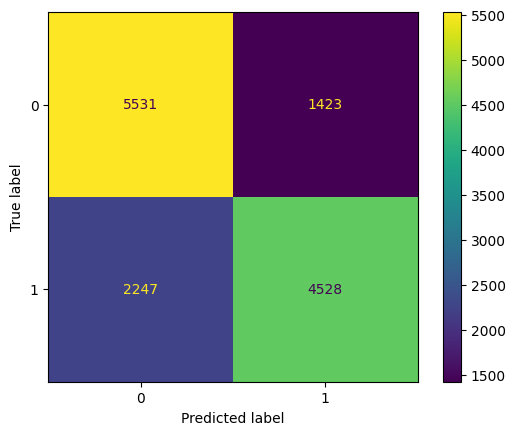

In [21]:
# concat val och train



def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot()

evaluate_model(results["random forest set2"]["model"], norm_X2_train, norm_X2_test, y2_train, y2_test)
